# Learners

> Fill in a module description here

In [ ]:
#| default_exp learners

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export


import torch
import torch.nn as nn
from torch.nn.modules import linear
import torch.optim as optim
import pytorch_lightning as pl
import pylab as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchdiffeq import odeint as odeint
from typing import List, Tuple, Union
from deepPRC.layers import *
from deepPRC.datatools import *

import itertools




In [ ]:
#| export

class PRCLearner(pl.LightningModule):

    def __init__(self,
                 model: torch.nn.Module,
                 data: SimPRCData or PRCData,
                 batch_size: int = 5,
                 learning_rate: float = 1e-2,
                 weight_decay: float = 1e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.data = data
        self.batch_size = batch_size
        self.model = model
        self.lossSaved = []
        self.training_epoch_loss = []
        self.weight_decay = weight_decay

    def forward(self, ic, ts, coeffs, ts_coeffs):
        self.model.update_coeff(coeffs, ts_coeffs)
        yout = odeint(self.model,
                        ic,
                        ts,
                        method='rk4',
                        options=dict(step_size=1.0))
        return yout[:, -1] # the last time point

    def training_step(self, batch, batch_idx):
        batch_y0, batch_t, batch_phase, batch_coeff, batch_ts_coeffs = batch
        pred_y = torch.full_like(batch_phase, fill_value=0.0)
        for k in range(batch_t.shape[0]):
            pred_y[k, ...] = self.forward(batch_y0[k], 
                                          batch_t[k], 
                                          batch_coeff[k], 
                                          batch_ts_coeffs[k])
        loss = (2.0*torch.sin(0.5*(pred_y-batch_phase))**2).sum()
        self.lossSaved.append(loss)
        self.training_epoch_loss.append(loss)
        return {'loss': loss}

    def configure_optimizers(self):
        # Create a Pytorch lightning optimizer and scheduler
        self.opt = optim.Adam(self.parameters(), 
                              lr=self.learning_rate, 
                              weight_decay=self.weight_decay)
        self.reduce_lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt,
            mode='min',
            factor=0.10,
            patience=1,
            min_lr=1e-6,
            threshold=1e-2,
            verbose=True
        )
        return [self.opt]  # , [self.reduce_lr_on_plateau]

    def training_epoch_end(self, outputs):
        pass
        # mean_loss_training = torch.mean(torch.tensor(self.training_epoch_loss))
        # print("Mean loss training{}".format(mean_loss_training))
        # self.reduce_lr_on_plateau.step(mean_loss_training)
        # self.training_epoch_loss = []
        # return {}

    def plot(self):
        plt.figure()
        ax = plt.gca()
        self.data.plot(ax)

        for (j, b) in enumerate(self.data):
            batch_y0, batch_t, batch_phase, batch_coeff, batch_coeff_ts = b
            pred_y = self.forward(
                batch_y0, batch_t, batch_coeff, batch_coeff_ts).detach()
            ax.plot(batch_t, torch.sin(pred_y),
                    ls='--', alpha=0.50, color='red')
        plt.show()

    def train_dataloader(self):
        trainloader = DataLoader(
            self.data, batch_size=self.batch_size, shuffle=True)
        return trainloader



In [ ]:
#| export 

def train_mouse(use_ann: bool = True, epochs: int = 30):
    ics = torch.tensor([0.70, 0.0])
    train_durations = [4, 9, 18]
    test_durations = [3, 6, 12]

    data = loadComas(durations=train_durations)
    if use_ann:
        knn = SmallPerturbationModel(
            tau=23.8, inner_layers_forcing=10, use_nn_autonomous=True)
    else:
        knn = SmallPerturbationModel(
            tau=23.8, use_nn_autonomous=False, use_nn_perturbation=False)
    model_learner = PRCLearner(knn,
                               data,
                               batch_size=12,
                               learning_rate=1e-2)

    trainer = pl.Trainer(max_epochs=epochs,
                         auto_lr_find=False,
                         log_every_n_steps=1,
                         accelerator='cpu',
                         gpus=0)
    trainer.fit(model_learner)

    model_learner.batch_size = 24
    trainer = pl.Trainer(max_epochs=5,
                         auto_lr_find=False,
                         gpus=0)
    trainer.fit(model_learner)

    fig = plt.figure()
    gs = fig.add_gridspec(2, 3, wspace=0)
    (top, bottom) = gs.subplots(sharey=True)

    print("Making plots.....")

    for idx, duration in enumerate(train_durations):
        dataFit = loadComas(durations=[duration])
        prc1 = find_prc(model_learner, dataFit.forcing_funcs, ics)
        top[idx].plot(np.linspace(0, 2*torch.pi, len(prc1)),
                      prc1, color='darkgreen')
        top[idx].scatter(np.linspace(
            0, 2*torch.pi, len(dataFit.simple_phases)), dataFit.simple_phases, color='k')
        top[idx].set_title(f"Training {duration} PRC")
        # top[idx].set_xlabel("Phase")
        # top[idx].set_xticklabels([])
    top[0].set_ylabel("Phase Shift")

    for idx, duration in enumerate(test_durations):
        dataFit = loadComas(durations=[duration])
        prc1 = find_prc(model_learner, dataFit.forcing_funcs, ics)
        bottom[idx].plot(np.linspace(0, 2*torch.pi, len(prc1)),
                         prc1, color='darkgreen')
        bottom[idx].scatter(np.linspace(
            0, 2*torch.pi, len(dataFit.simple_phases)), dataFit.simple_phases, color='k')
        bottom[idx].set_title(f"Test {duration} PRC")
        bottom[idx].set_xlabel("Phase")

    bottom[0].set_ylabel("Phase Shift")
    plt.show()



In [ ]:
#| export 


def train_sim_model(
        model: torch.nn.Module,
        use_ann: bool = True,
        epochs: int = 30):

    # Define a training dataset
    train_experiments = [construct_prc_pulses(0.2, 1.0, 24.0, samples=12, num_periods=2),
                         construct_prc_pulses(
                             0.1, 1.0, 24.0, samples=12, num_periods=2),
                         construct_prc_pulses(0.4, 1.0, 24.0, samples=12, num_periods=2)]
    pulses = list(itertools.chain.from_iterable(train_experiments))

    # Test pules not seen during training
    test_pulses = [construct_prc_pulses(0.7, 1.0, 24.0, samples=24),
                   construct_prc_pulses(0.25, 2.0, 24.0, samples=24)]

    total_experiments = train_experiments + test_pulses
    ics = torch.tensor([0.7, 0.0])
    sim_data = SimPRCData(model, pulses, ics)

    if use_ann:
        learned_model = SmallPerturbationModel(
            tau=24.0, use_nn_perturbation=True, inner_layers_forcing=10, use_nn_autonomous=False)
    else:
        learned_model = SmallPerturbationModel(
            tau=24.0, use_nn_perturbation=False, use_nn_autonomous=False)

    model_learner = PRCLearner(learned_model,
                               sim_data,
                               batch_size=12,
                               learning_rate=1e-2)

    trainer = pl.Trainer(max_epochs=epochs,
                         auto_lr_find=True,
                         log_every_n_steps=1,
                         accelerator='cpu')
    trainer.fit(model_learner)

    fig = plt.figure()
    gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
    (ax1, ax2) = gs.subplots(sharey=True)

    # Training pulses

    # create a colormap for the training pulses
    cmap = plt.get_cmap('jet')# type: ignore    
    for (idx, pulse_exp) in enumerate(train_experiments):
        prc1 = find_prc(model_learner.model, pulse_exp, ics)
        prc_exp = find_prc_exp(model, pulse_exp, ics)
        ax1.plot(np.linspace(0, 2*torch.pi, len(prc1)), prc1,
                 color=cmap(idx/len(total_experiments)))
        ax1.scatter(np.linspace(0, 2*torch.pi, len(prc_exp)),
                    prc_exp, color=cmap(idx/len(total_experiments)))

    ax1.set_title("Training PRCs")
    ax1.set_xlabel("Phase")
    ax1.set_ylabel("Phase Shift")

    for (idx, test_pulse) in enumerate(test_pulses):
        idx += len(train_experiments)
        prc1 = find_prc(model_learner.model, test_pulse, ics)
        prc_exp = find_prc_exp(model, test_pulse, ics)
        ax2.plot(np.linspace(0, 2*torch.pi, len(prc1)), prc1,
                 color=cmap(idx/len(total_experiments)))
        ax2.scatter(np.linspace(0, 2*torch.pi, len(prc_exp)),
                    prc_exp, color=cmap(idx/len(total_experiments)))
    ax2.set_title("Test PRCs")
    ax2.set_xlabel("Phase")
    plt.show()


In [ ]:

# sim_model = PolarModel(A=[1.0,0.80])
# train_sim_model(sim_model, use_ann=False, epochs=30)


In [ ]:

#train_sim_model(sim_model, use_ann=True, epochs=30)



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | SmallPerturbationModel | 171   
-------------------------------------------------
171       Trainable params
0         Non-trainable params
171       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


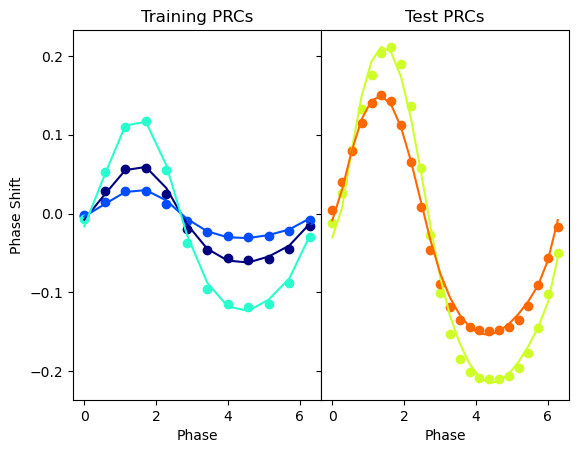

In [ ]:
vdp_model = VDP()

train_sim_model(vdp_model, use_ann=True, epochs=20)



GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | SmallPerturbationModel | 9     
-------------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


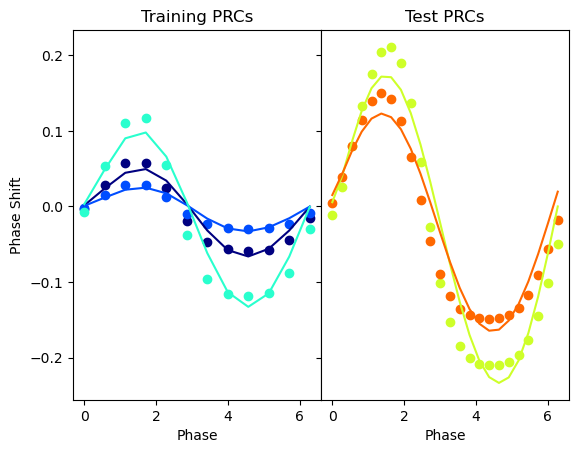

In [ ]:
train_sim_model(vdp_model, use_ann=False, epochs=20)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()